In [71]:
import numpy as np
import pandas as pd
from os import path
from collections import OrderedDict
from tqdm import tqdm
from typing import Dict

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Flatten, Input, Lambda
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

from sklearn.metrics import roc_auc_score

from itertools import islice
%matplotlib inline

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('../ml-100k/u.data', sep='\t', names=columns)
ratings.drop('timestamp', axis=1, inplace=True)

columns = ['item_id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../ml-100k/u.item', sep='|', names=columns, encoding='latin-1')
movies = movies[['item_id', 'movie title']]

In [4]:
ratings

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [5]:
ratings['user_id'] = ratings['user_id'] - 1
ratings['item_id'] = ratings['item_id'] - 1
ratings

,user_id,item_id,rating
0,195,241,3
1,185,301,3
2,21,376,1
3,243,50,2
4,165,345,1
...,...,...,...
99995,879,475,3
99996,715,203,5
99997,275,1089,1
99998,12,224,2


In [6]:
sorted(ratings.item_id.unique())[-10:]

[1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681]

In [7]:
sorted(ratings.user_id.unique())[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
unique_users = ratings.user_id.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_movies = ratings.item_id.unique()
item_ids = dict(zip(unique_movies, np.arange(unique_movies.shape[0], dtype=np.int32)))

In [9]:
tmp_test = ratings[ratings.rating > 4]
tmp_test = tmp_test.groupby('user_id').item_id.count().reset_index()

In [10]:
conditions = (ratings.user_id.isin(tmp_test[tmp_test.item_id > 20].user_id)) & (ratings.rating > 4)
df_test = ratings[conditions].groupby('user_id').head(2).reset_index()
del df_test['index']
df_test.shape

(698, 3)

In [11]:
ground_truth_test = df_test.groupby('user_id').item_id.agg(list).reset_index()
ground_truth_test.head()

,user_id,item_id
0,0,"[201, 170]"
1,4,"[381, 435]"
2,5,"[13, 97]"
3,6,"[491, 660]"
4,7,"[21, 49]"


In [12]:
df_train = pd.concat([ratings, df_test]).drop_duplicates(keep=False)
df_train.shape

(99302, 3)

In [13]:
ground_truth_train = df_train[df_train.rating > 3].groupby('user_id').item_id.agg(list).reset_index()

ground_truth_train.head()

,user_id,item_id
0,0,"[60, 32, 159, 19, 264, 46, 221, 252, 112, 226,..."
1,1,"[291, 250, 49, 296, 12, 302, 256, 315, 300, 31..."
2,2,"[330, 327, 317, 347, 326, 320, 259, 319, 341, ..."
3,3,"[302, 360, 356, 259, 293, 287, 49, 353, 270, 2..."
4,4,"[16, 0, 210, 61, 23, 422, 266, 221, 172, 41, 4..."


In [14]:
df_triples = pd.DataFrame(columns=['user_id', 'positive_id', 'negative_id'], dtype=np.int32)
df_triples

,user_id,positive_id,negative_id


In [15]:
data = []
users_without_data = []

for user_id in tqdm(df_train.user_id.unique()):
    positive_items = df_train[(df_train.user_id == user_id) & (df_train.rating > 3)].item_id.values
    negative_items = df_train[(df_train.user_id == user_id) & (df_train.rating <= 3)].item_id.values

    if negative_items.shape[0] == 0 or positive_items.shape[0] == 0:
        users_without_data.append(user_id)
        continue

    for positive_item in positive_items:
        for negative_item in negative_items:
            data.append({'user_id' : user_id , "positive_id" : positive_item, "negative_id": negative_item})

df_triples = df_triples.append(data, ignore_index=True)

100%|██████████| 943/943 [00:01<00:00, 485.54it/s]
C:\Users\Yungi\AppData\Local\Temp\ipykernel_104564\1880062381.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_triples = df_triples.append(data, ignore_index=True)


In [16]:
df_triples.shape

(4349304, 3)

In [17]:
df_train.shape

(99302, 3)

In [18]:
n_users = unique_users.shape[0]
n_items = unique_movies.shape[0]

n_users, n_items

(943, 1682)

In [19]:
unique_item_ids = list(ratings.item_id.unique())

In [20]:
def bpr_predict(model: Model, user_id: int, item_ids: list, user_layer="user_embedding", item_layer="item_embedding"):
    user_vector = model.get_layer(user_layer).get_weights()[0][user_id]
    item_matrix = model.get_layer(item_layer).get_weights()[0][item_ids]

    scores = (np.dot(user_vector, item_matrix.T))

    return scores

In [21]:
@tf.function
def identity_loss(_, y_pred):
    return tf.math.reduce_mean(y_pred)

In [22]:
@tf.function
def bpr_triples_loss(X: dict):
    positive_item_latent, negative_item_latent, user_latent = X

    positive_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, positive_item_latent), axis=-1, keepdims=True)
    negative_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, negative_item_latent), axis=-1, keepdims=True)

    return tf.math.subtract(tf.constant(1.0), tf.sigmoid(tf.math.subtract(positive_interactions, negative_interactions)))

In [23]:
def out_shape(shapes):
    return shapes[0]

In [24]:
def build_model(num_users: int, num_items: int, latent_dim: int) -> Model:
    user_input = Input(shape=(1, ), name='user_input')

    positive_item_input = Input(shape=(1, ), name='positive_item_input')
    negative_item_input = Input(shape=(1, ), name='negative_item_input')

    item_embedding_layer = Embedding(num_items, latent_dim, name="item_embedding", input_length=1)

    positive_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_embedding = Flatten()(item_embedding_layer(negative_item_input))

    user_embedding = Embedding(num_users, latent_dim, name="user_embedding", input_length=1)(user_input)
    user_embedding = Flatten()(user_embedding)

    triplet_loss = Lambda(bpr_triples_loss, output_shape=out_shape)([positive_embedding, negative_embedding, user_embedding])

    model = Model(inputs=[positive_item_input, negative_item_input, user_input], outputs=triplet_loss)

    return model

In [25]:
latent_dim = 20
batch_size = 256
num_epochs = 1
lr = 0.001

model = build_model(n_users, n_items, latent_dim)
model.compile(loss=identity_loss, optimizer=Adam(learning_rate=lr))

In [26]:
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total number of parameters: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable number of parameters: {:,}'.format(trainable_count))
print('Non-trainable number of parameters: {:,}'.format(non_trainable_count))

print('Training data length: {:,}'.format(df_triples.shape[0]))

Total number of parameters: 52,500.0
Trainable number of parameters: 52,500
Non-trainable number of parameters: 0.0
Training data length: 4,349,304


In [27]:
X = {
    'user_input': tf.convert_to_tensor(df_triples.user_id),
    'positive_item_input': tf.convert_to_tensor(df_triples.positive_id),
    'negative_item_input' : tf.convert_to_tensor(df_triples.negative_id)
}

In [28]:
model.fit(X,
          tf.ones(df_triples.shape[0]),
          batch_size=batch_size,
          epochs=num_epochs)

16990/16990 [==============================] - 103s 6ms/step - loss: 0.1424


In [29]:
model.save(path.join('./', "model.h5"))

In [31]:
def full_auc(model: Model, ground_truth: Dict[int, list], items: list) -> float:
    """
    Measure AUC for model and ground truth for all items

    :param model:
    :param ground_truth: dictionary of the users and the high ranked movies for the specific user
    :param items: a list of the all available movies
    :return: AUC
    """

    number_of_items = len(items)
    scores = []

    for user_id, true_item_ids in ground_truth:
        predictions = bpr_predict(model, user_id, items)
        grnd = np.zeros(number_of_items, dtype=np.int32)

        for p in true_item_ids:
            index = items.index(p)
            grnd[index] = 1

        if true_item_ids:
            scores.append(roc_auc_score(grnd, predictions))

    return sum(scores) / len(scores)

In [32]:
def mean_average_precision_k(model: Model,
                           ground_truth: Dict[int, list],
                           items: list,
                           k=100) -> float:
    """
    Calculate mean eavarage precission per user

    :param model:
    :param ground_truth: dictionary of the users and the high ranked movies for the specific user
    :param items: a list of the all available movies
    :param k: top N recommendations per user
    :return: mean eavarage precission
    """
    scores = []

    for user, actual in ground_truth:
        predictions = bpr_predict(model, user, items)
        predictions = dict(zip(items, predictions))
        predictions = sorted(predictions.items(), key=lambda kv: kv[1], reverse=True)[:k]
        predictions = list(OrderedDict(predictions).keys())

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predictions):
            if p in actual:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        score = score / min(len(actual), k)
        scores.append(score)

    return np.mean(scores)

In [33]:
print(f'AUC Train : {full_auc(model, ground_truth_train.values, unique_item_ids)}')

AUC Train : 0.8095585804743946


In [36]:
print(f'AUC Test : {full_auc(model, ground_truth_test.values, unique_item_ids)}')

AUC Test : 0.7714456269613866


In [35]:
print(f'Mean Average precision test : {mean_average_precision_k(model, ground_truth_test.values, unique_item_ids)}')

Mean Average precision test : 0.03232934578624193


In [37]:
predictions = bpr_predict(model, 1, unique_item_ids)

In [39]:
predictions.shape[0]

1682

In [45]:
ratings[ratings.user_id == 0]['item_id']

202       60
305      188
333       32
334      159
478       19
        ... 
92049     27
92487    171
94019    121
96699    151
99073     93
Name: item_id, Length: 272, dtype: int64

In [51]:
score = bpr_predict(model, 2, unique_item_ids)

In [56]:
score[[0, 2, 4, 5]][::-1]

array([ 1.8362949,  3.7051764, -4.0658736,  4.9398355], dtype=float32)

In [64]:
def _recommend_user( model, ratings, user, N):
    scores = bpr_predict(model, user, unique_item_ids)
    positive_items = df_train[(ratings.user_id == user) & (ratings.rating > 3)].item_id.values
    liked = set(positive_items)
    count = N + len(positive_items)
    if count < scores.shape[0]:
        ids = np.argpartition(scores, -count)[-count:]
        best_ids = np.argsort(scores[ids])[::-1]
        best = ids[best_ids]
    else:
        best = np.argsort(scores)[::-1]
    top_n = list(islice((rec for rec in best if rec if rec not in liked), N))
    return top_n

def recommand(n_users, ratings, model, unique_item_ids, N=10):
    recommendation = np.zeros((n_users, N), dtype=np.uint32)
    for user in range(n_users):
        top_n = _recommend_user(model, ratings, user, N)
        recommendation[user] = top_n
    return recommendation



In [68]:
recommand(n_users, ratings, model, unique_item_ids, N=10)

C:\Users\Yungi\AppData\Local\Temp\ipykernel_104564\1215669016.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_items = df_train[(ratings.user_id == user) & (ratings.rating > 3)].item_id.values


array([[ 277,  661,  635, ...,  357, 1177,  662],
       [ 569,  661, 1195, ...,  662,  277,  896],
       [ 174,  254,  275, ...,   66,  819,  843],
       ...,
       [ 189,  541,  130, ...,  239,  660,  240],
       [ 133,  482,   40, ...,  189,  289,   66],
       [ 408,  321,  130, ...,   31,  725,  612]], dtype=uint32)

In [70]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 positive_item_input (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 negative_item_input (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                              

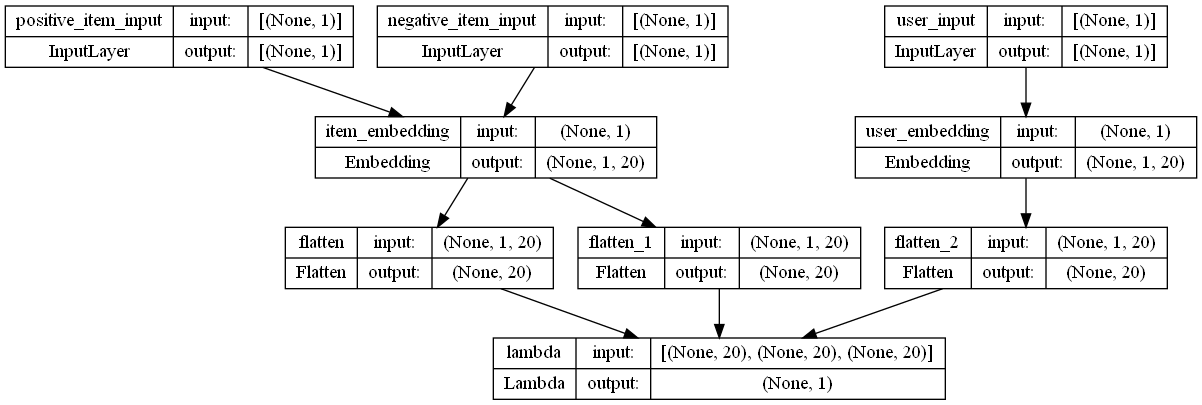

In [72]:
plot_model(model, to_file="model.png", show_shapes=True)